# Manipulating meteorological data
### Python workshop, EMS2019

This is **not** xarray tutorial, nor jupyter tutorial, nor visualisation tutorial.  

This part of workshop is about exploring meteorological data from the CDS.

All tools are just that - tools.

Use this notebook as a starting point, and the rest of internet to learn further.

# Importing libraries
First, we're going to import libraries used by this notebook.  
[cdsapi](https://cds.climate.copernicus.eu/api-how-to) - to access the data  
[pandas](https://pandas.pydata.org/pandas-docs/stable/) and [xarray](http://xarray.pydata.org/en/stable/') - to manipulate the data  
[matplotlib]('https://matplotlib.org/') and [seaborn]('https://seaborn.pydata.org/') - for plotting



In [43]:
import cdsapi
import pandas as pd
import seaborn as sns
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta
import numpy as np

# The data
We will be using already downloaded data. Let's see what is in our directory.  
All weather data is in **data/weather** directory.

Using Jupyter's Built-in magic commands we can access shell commands. They all start with %. More about magic comands [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html).  

In [2]:
%ls -rtl data/weather/*.nc data/weather/*.grib

-rw-rw-r--. 1 jovyan users 22707360 Jul  4 08:04 data/weather/monthly_data.grib
-rw-rw-r--. 1 jovyan users 23189760 Jul 26 17:12 data/weather/london_data_2012.grib
-rw-rw-r--. 1 jovyan users  4953600 Aug 22 16:18 data/weather/ensemble_data_pl.grib
-rw-r--r--. 1 jovyan users 46919504 Sep  6 12:35 data/weather/min_max_t_and_wind_gust.nc
-rw-r--r--. 1 jovyan users 46958400 Sep  6 12:35 data/weather/min_max_t_and_wind_gust.grib
-rw-r--r--. 1 jovyan users 13079092 Sep  6 12:38 data/weather/simple_data.nc


## GRIB & netCDF
First we inspect what is in **min_max_t_and_wind_gust.nc** and **min_max_t_and_wind_gust.grib** files.  
We got the netCDF file from the *Example 4 - Hourly ERA5 data in netcdf format* in CDSAPI_examples notebook, and the grib with a modified version of that request.  

They contain the same hourly reanalysis data for 5 days in 2018 for three variables: Wind gusts at 10 m, Minimum and Maximum 2 m temperature.  

Lets open both and see how they are both structured.

NetCDF is pretty straigtforward.

In [3]:
ds_nc = xr.open_dataset('data/weather/min_max_t_and_wind_gust.nc')
ds_nc

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 120)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 2018-04-28 ... 2018-05-02T23:00:00
Data variables:
    fg10       (time, latitude, longitude) float32 ...
    mx2t       (time, latitude, longitude) float32 ...
    mn2t       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-03 08:58:45 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

**xarray** can't handle grib files out of the box. For this we need to use [**cfgrib**](https://github.com/ecmwf/cfgrib) as an engine.

In [4]:
ds_grib = xr.open_dataset('data/weather/min_max_t_and_wind_gust.grib',engine='cfgrib')
ds_grib

<xarray.Dataset>
Dimensions:     (latitude: 181, longitude: 360, step: 12, time: 11)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-04-27T18:00:00 ... 2018-05-02T18:00:00
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
    surface     int64 ...
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    fg10        (time, step, latitude, longitude) float32 ...
    mx2t        (time, step, latitude, longitude) float32 ...
    mn2t        (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Ra

We can now see the differences in the NetCDF and GRIB metadata loaded into xarray dataset.  

There are also differences in the structure of the dataset.  

- Dataset loaded from netCDF has only one time coordinate and dimension  
- Dataset loaded from GRIB file has time and step.  

This is because these 3 fields don't have instantaneous values, but minimum or maximum over some period. This kind of fields have the type as forecast, and in grib they contain start of the forecast and step as dimensions but also a **valid_time** as coordinate.  
More about this in the [ERA5 documentation](https://confluence.ecmwf.int/pages/viewpage.action?pageId=85402030#ERA5terminology:analysisandforecast;timeandsteps;instantaneousandaccumulatedandmeanratesandmin/maxparameters-'step'andinstantaneous,accumulatedandmin/maxparameters)

We can get more metadata for each variable by inspecting them separately.

In [5]:
ds_nc.fg10

<xarray.DataArray 'fg10' (time: 120, latitude: 181, longitude: 360)>
[7819200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 2018-04-28 ... 2018-05-02T23:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre wind gust since previous post-processing

In [6]:
ds_grib.fg10

<xarray.DataArray 'fg10' (time: 11, step: 12, latitude: 181, longitude: 360)>
[8601120 values with dtype=float32]
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-04-27T18:00:00 ... 2018-05-02T18:00:00
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
    surface     int64 ...
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    valid_time  (time, step) datetime64[ns] ...
Attributes:
    GRIB_paramId:                             49
    GRIB_shortName:                           10fg
    GRIB_units:                               m s**-1
    GRIB_name:                                10 metre wind gust since previo...
    GRIB_cfVarName:                           fg10
    GRIB_dataType:                            fc
    GRIB_missingValue:                        9999
    GRIB_numberOfPoints:                      65160
    G

Let's convert to pandas dataframe just to see what our data actually looks like. We will not be doing any calculations using pandas.

In [7]:
ds_nc.to_dataframe().head(15)

fg10        mx2t        mn2t
latitude longitude time                                                 
90.0     0.0       2018-04-28 00:00:00  5.117364  256.036438  256.028870
                   2018-04-28 01:00:00  5.044372  256.047302  256.037933
                   2018-04-28 02:00:00  4.901329  256.081757  256.048828
                   2018-04-28 03:00:00  4.702953  256.130676  256.090515
                   2018-04-28 04:00:00  4.396266  256.226746  256.137665
                   2018-04-28 05:00:00  4.170224  256.288361  256.242798
                   2018-04-28 06:00:00  3.981267  256.440613  256.300842
                   2018-04-28 07:00:00  3.639850  256.241241  256.184784
                   2018-04-28 08:00:00  3.364948  256.301056  256.246429
                   2018-04-28 09:00:00  3.085928  256.453308  256.313507
                   2018-04-28 10:00:00  2.783951  256.551178  256.476685
                   2018-04-28 11:00:00  2.456659  256.770477  256.570984
                   2018-04-28 12:00:00  2.248867  256.935425  256.804871
                   2018-04-28 13:00:00  2.115831  257.107605  256.968048
                   2018-04-28 14:00:00  2.305965  257.194611  257.129395

In [8]:
ds_grib.to_dataframe().head(15)

number  surface  \
latitude longitude step     time                                   
90.0     0.0       01:00:00 2018-04-27 18:00:00       0        0   
                            2018-04-28 06:00:00       0        0   
                            2018-04-28 18:00:00       0        0   
                            2018-04-29 06:00:00       0        0   
                            2018-04-29 18:00:00       0        0   
                            2018-04-30 06:00:00       0        0   
                            2018-04-30 18:00:00       0        0   
                            2018-05-01 06:00:00       0        0   
                            2018-05-01 18:00:00       0        0   
                            2018-05-02 06:00:00       0        0   
                            2018-05-02 18:00:00       0        0   
                   02:00:00 2018-04-27 18:00:00       0        0   
                            2018-04-28 06:00:00       0        0   
                            2018-04-28 18:00:00       0        0   
                            2018-04-29 06:00:00       0        0   

                                                         valid_time      fg10  \
latitude longitude step     time                                                
90.0     0.0       01:00:00 2018-04-27 18:00:00 2018-04-27 19:00:00       NaN   
                            2018-04-28 06:00:00 2018-04-28 07:00:00  3.639782   
                            2018-04-28 18:00:00 2018-04-28 19:00:00  2.743057   
                            2018-04-29 06:00:00 2018-04-29 07:00:00  4.606690   
                            2018-04-29 18:00:00 2018-04-29 19:00:00  4.943463   
                            2018-04-30 06:00:00 2018-04-30 07:00:00  3.737045   
                            2018-04-30 18:00:00 2018-04-30 19:00:00  2.514566   
                            2018-05-01 06:00:00 2018-05-01 07:00:00  1.332501   
                            2018-05-01 18:00:00 2018-05-01 19:00:00  3.969260   
                            2018-05-02 06:00:00 2018-05-02 07:00:00  9.522531   
                            2018-05-02 18:00:00 2018-05-02 19:00:00  7.866532   
                   02:00:00 2018-04-27 18:00:00 2018-04-27 20:00:00       NaN   
                            2018-04-28 06:00:00 2018-04-28 08:00:00  3.365197   
                            2018-04-28 18:00:00 2018-04-28 20:00:00  3.095178   
                            2018-04-29 06:00:00 2018-04-29 08:00:00  4.645340   

                                                       mx2t        mn2t  
latitude longitude step     time                                         
90.0     0.0       01:00:00 2018-04-27 18:00:00         NaN         NaN  
                            2018-04-28 06:00:00  256.240417  256.185059  
                            2018-04-28 18:00:00  258.047791  257.945129  
                            2018-04-29 06:00:00  260.090515  259.866028  
                            2018-04-29 18:00:00  260.620819  260.568359  
                            2018-04-30 06:00:00  260.501373  260.436096  
                            2018-04-30 18:00:00  261.093140  261.049194  
                            2018-05-01 06:00:00  260.327148  260.283569  
                            2018-05-01 18:00:00  259.037323  258.934875  
                            2018-05-02 06:00:00  260.912720  260.318237  
                            2018-05-02 18:00:00  265.369232  265.090179  
                   02:00:00 2018-04-27 18:00:00         NaN         NaN  
                            2018-04-28 06:00:00  256.301270  256.247131  
                            2018-04-28 18:00:00  258.146057  258.068848  
                            2018-04-29 06:00:00  260.299500  260.139374

## Selecting a subarea
Data downloaded from Web download service is always global. Using the CDSAPI we can retrieve smaller area, but if we already have a global field we can select the subarea using the **sel()** method.  
Using the same method we can select any dimension.  We can select only one point or all the points between the interval.

In this example we will select the subarea and one time step so we can plot it to check the area.

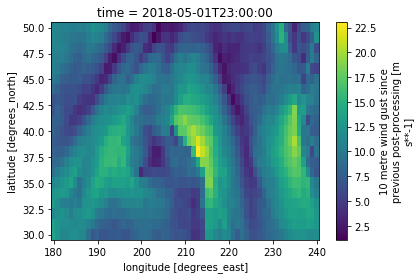

In [9]:
europe = ds_nc.sel(latitude=slice(50,30), longitude=slice(180,240))
europe_one_day = europe.sel(time='2018-05-01T23:00:00')
europe_one_day.fg10.plot()

## Calculating daily data
ERA5 data has hourly data, and we might need to calculate daily mean, minimum and maximum temperatures, or daily sum of precipitation. Xarray has handy method **resample** which does this for us with one line of code.  
However it only works on time dimension, and in the GRIB files from previous example time dimension is actually start of the forecast, which is every day at 6 and 18 UTC. This is why it would not be trivial to resample data from hourly to daily.  
We will start with some simpler dataset.

We will first calculate daily mean of all four parameters in our dataset.

In [10]:
ds_simple = xr.open_dataset('data/weather/simple_data.nc')
ds_simple

<xarray.Dataset>
Dimensions:    (latitude: 69, longitude: 141, time: 168)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 24.5 24.75 25.0
  * latitude   (latitude) float32 52.0 51.75 51.5 51.25 ... 35.5 35.25 35.0
  * time       (time) datetime64[ns] 2010-09-03 ... 2010-09-09T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    deg0l      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-02 20:56:38 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [11]:
mean_ds = ds_simple.resample(time='D').mean()
mean_ds

<xarray.Dataset>
Dimensions:    (latitude: 69, longitude: 141, time: 7)
Coordinates:
  * time       (time) datetime64[ns] 2010-09-03 2010-09-04 ... 2010-09-09
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 24.5 24.75 25.0
  * latitude   (latitude) float32 52.0 51.75 51.5 51.25 ... 35.5 35.25 35.0
Data variables:
    u10        (time, latitude, longitude) float32 -2.9323006 ... 1.0879999
    v10        (time, latitude, longitude) float32 4.1682754 ... -0.41435847
    t2m        (time, latitude, longitude) float32 289.1931 ... 297.75415
    deg0l      (time, latitude, longitude) float32 4086.2888 ... 4548.3745

### Resampling individual variables
In reality we might not want to calculate same things for all variables. Let's calculate minimum of T2m.  
And to convert to Celsius on the fly.  

When using resample on individual variables, we need to tell xarray on which dimension to calculate minimum. Otherwise it will calculate it for all dimensions. And we only want it on time, not latitudes or longitudes.

In [12]:
min_t = ds_simple.t2m.resample(time='D').min('time')-273.15
min_t

<xarray.DataArray 't2m' (time: 7, latitude: 69, longitude: 141)>
array([[[13.426636, 12.586487, ...,  6.784058,  6.725464],
        [14.31955 , 13.377716, ...,  7.046082,  6.997131],
        ...,
        [21.507416, 21.616882, ..., 18.09021 , 18.39151 ],
        [21.53897 , 21.677399, ..., 22.352081, 20.66278 ]],

       [[12.831787, 12.704956, ...,  4.174774,  4.155487],
        [13.67514 , 12.777039, ...,  4.088531,  4.114258],
        ...,
        [22.02182 , 22.227814, ..., 18.37799 , 18.184204],
        [22.16153 , 22.354645, ..., 23.012604, 20.815369]],

       ...,

       [[12.573608, 11.48819 , ...,  8.540955,  8.388367],
        [13.592712, 12.556244, ...,  8.550598,  8.421844],
        ...,
        [21.42694 , 21.3703  , ..., 19.285095, 19.474365],
        [21.53189 , 21.500977, ..., 23.270111, 21.956787]],

       [[11.704498, 10.534088, ...,  7.328033,  7.208954],
        [13.28241 , 11.913727, ...,  7.358948,  7.235992],
        ...,
        [21.3143  , 21.450775, ..., 18

It seems like this converted our data to DataArray. Just to to_dataset() to get the data back as Xarray Dataset

In [13]:
min_t_ds = min_t.to_dataset()
min_t_ds

<xarray.Dataset>
Dimensions:    (latitude: 69, longitude: 141, time: 7)
Coordinates:
  * time       (time) datetime64[ns] 2010-09-03 2010-09-04 ... 2010-09-09
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 24.5 24.75 25.0
  * latitude   (latitude) float32 52.0 51.75 51.5 51.25 ... 35.5 35.25 35.0
Data variables:
    t2m        (time, latitude, longitude) float32 13.426636 ... 20.081451

We should check if this did what we wanted. We should get the same thing if we now select one point and check the data as if we first select the point and then do resampling.

In [14]:
A = min_t_ds.sel(latitude=51.5, longitude = 0.12, method='nearest')
A.to_dataframe()

,longitude,latitude,t2m
time,,,
2010-09-03,0.0,51.5,10.635162
2010-09-04,0.0,51.5,9.557465
2010-09-05,0.0,51.5,12.598083
2010-09-06,0.0,51.5,13.395721
2010-09-07,0.0,51.5,12.451294
2010-09-08,0.0,51.5,12.484772
2010-09-09,0.0,51.5,12.153229


In [15]:
B = ds_simple.t2m.sel(latitude=51.5, longitude = 0.12, method='nearest').resample(time='D').min()-273.15
B.to_dataframe()

,longitude,latitude,t2m
time,,,
2010-09-03,0.0,51.5,10.635162
2010-09-04,0.0,51.5,9.557465
2010-09-05,0.0,51.5,12.598083
2010-09-06,0.0,51.5,13.395721
2010-09-07,0.0,51.5,12.451294
2010-09-08,0.0,51.5,12.484772
2010-09-09,0.0,51.5,12.153229


Now that we know what we're doing, we can calculate the maximum of wind speed.

But we need to calculate wind speed first.

In [16]:
u = ds_simple.u10
v = ds_simple.v10
speed = xu.sqrt(u**2+v**2)

And now we can calculate daily maximum speed and convert it back to dataset. 
We are renaming the resulting DataArray in order to convert it to dataset.

In [17]:
daily_max_speed = speed.resample(time='D').max('time')
daily_max_speed = daily_max_speed.rename('speed')
daily_max_speed_ds = daily_max_speed.to_dataset()
daily_max_speed_ds

<xarray.Dataset>
Dimensions:    (latitude: 69, longitude: 141, time: 7)
Coordinates:
  * time       (time) datetime64[ns] 2010-09-03 2010-09-04 ... 2010-09-09
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 24.5 24.75 25.0
  * latitude   (latitude) float32 52.0 51.75 51.5 51.25 ... 35.5 35.25 35.0
Data variables:
    speed      (time, latitude, longitude) float32 6.132203 ... 4.0753055

## But... accumulated, min/max and mean parameters are different

Remember, values for these parameters are not at the specific time, but acumulated between two steps. Midnight is the first time in the day, and it contains the data from the last hour in the previous day.  
This means, when calculating daily statistics using **'D'** it will belong to the wrong day.

We can correct this by removing the data for the first time step, at midnight on the first day. It belongs to previous day and we don't need it. From then, instead of using 'D' as frequency, we can use '24H'.  

Using **where()** method we can filter out the first 00 step. Where() is very usefuly for filtering data. You can find more info in the [xarray documentation](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html).

In [18]:
condition = ds_nc.time > ds_nc.time[0]
ds_nc_modified = ds_nc.where(condition, drop=True)

In [19]:
B = ds_nc_modified.mn2t.sel(latitude=51.5, longitude = 0.12, method='nearest').resample(time='24H').min()-273.15
B.to_dataframe()

,longitude,latitude,mn2t
time,,,
2018-04-28,0.0,52.0,6.523010
2018-04-29,0.0,52.0,6.142273
2018-04-30,0.0,52.0,4.827789
2018-05-01,0.0,52.0,2.739166
2018-05-02,0.0,52.0,5.558472


### Monthly to  quarterly resampling
CDS offers already calculated monthly statistics from ERA5 Dataset, in the **ERA5 monthly averaged data on single levels from 1979 to present** and **ERA5 monthly averaged data on pressure levels from 1979 to present** datasets. That is where our 'monthly_data.grib' file is coming from.   

In [20]:
monthly_ds = xr.open_dataset('data/weather/monthly_data.grib',engine='cfgrib')
monthly_ds

<xarray.Dataset>
Dimensions:     (latitude: 163, longitude: 289, time: 52)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2015-01-01T12:00:00 ... 2019-04-01T12:00:00
    step        timedelta64[ns] ...
    surface     int64 ...
  * latitude    (latitude) float64 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 -27.0 -26.75 -26.5 ... 44.5 44.75 45.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    u10         (time, latitude, longitude) float32 ...
    v10         (time, latitude, longitude) float32 ...
    t2m         (time, latitude, longitude) float32 ...
    msl         (time, latitude, longitude) float32 ...
    sst         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:            

Our data is monthly and we might want to match it to non-meteorological data that has quarterly interval.  

For example if we want seasonal means (DJF, MAM, JJA, and SON) we can use 'QS-DEC', meaning **quarterly starting with december**.  
Note: This method doesn't seem to take into account that months have different number of days. To find how to calculate proper weighted means, have a look at this example [here](https://github.com/pydata/xarray/blob/master/examples/xarray_seasonal_means.ipynb).

In [21]:
monthly_t2m = monthly_ds.t2m

In [22]:
quarterly_t2m = monthly_t2m.sel(latitude=51.5, longitude = 0.12, method='nearest').resample(time='QS-DEC').mean()-273.15
quarterly_t2m.to_dataframe()

,number,step,surface,latitude,longitude,t2m
time,,,,,,
2014-12-01,0,0 days,0,51.5,0.0,6.150421
2015-03-01,0,0 days,0,51.5,0.0,12.339722
2015-06-01,0,0 days,0,51.5,0.0,19.337463
2015-09-01,0,0 days,0,51.5,0.0,13.925476
2015-12-01,0,0 days,0,51.5,0.0,8.881287
2016-03-01,0,0 days,0,51.5,0.0,11.990662
2016-06-01,0,0 days,0,51.5,0.0,20.032379
2016-09-01,0,0 days,0,51.5,0.0,14.166656
2016-12-01,0,0 days,0,51.5,0.0,7.107391


We can use resample method to interpolate data too. We need to specify which method to use for the interpolation. Lets interpolate our London monthly data to daily intervals.  
We convert to Celsius on the fly too.

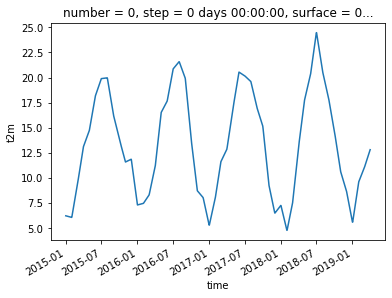

In [23]:
daily_t2m = monthly_t2m.sel(latitude=51.5, longitude = 0.12, method='nearest').resample(time='D').interpolate('linear')-273.15
daily_t2m.plot()

In [24]:
daily_t2m.to_dataframe().head(10)

,number,step,surface,latitude,longitude,t2m
time,,,,,,
2015-01-01,0,0 days,0,51.5,0.0,NaN
2015-01-02,0,0 days,0,51.5,0.0,6.229771
2015-01-03,0,0 days,0,51.5,0.0,6.224482
2015-01-04,0,0 days,0,51.5,0.0,6.219192
2015-01-05,0,0 days,0,51.5,0.0,6.213903
2015-01-06,0,0 days,0,51.5,0.0,6.208614
2015-01-07,0,0 days,0,51.5,0.0,6.203324
2015-01-08,0,0 days,0,51.5,0.0,6.198035
2015-01-09,0,0 days,0,51.5,0.0,6.192745


### Some datasets are different....

Let's see what the data from new **ERA5 Land** dataset looks like. In GRIB format we can notice big difference compared to ERA5 data. All the fields have time and step dimensions. In ERA5 this was the case only with accumulated and min/max parameters.   
ERA5 Land is made to be similar to ERA Interim. So here we have start every day at 00 and then 24 'forecast hours'.  

It makes life much easier when resampling to daily data.  

In [25]:
ds2 = xr.open_dataset('data/weather/london_data_2012.grib', engine='cfgrib')
ds2

<xarray.Dataset>
Dimensions:     (latitude: 11, longitude: 21, step: 24, time: 367)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2011-12-31 2012-01-01 ... 2012-12-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     int64 ...
  * latitude    (latitude) float64 52.0 51.9 51.8 51.7 ... 51.3 51.2 51.1 51.0
  * longitude   (longitude) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... 0.7 0.8 0.9 1.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    u10         (time, step, latitude, longitude) float32 ...
    v10         (time, step, latitude, longitude) float32 ...
    t2m         (time, step, latitude, longitude) float32 ...
    tp          (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
   

We will select the point in London to check what the data looks like.

In [26]:
tp = ds2.tp
tp_london = tp.sel(latitude=51.5, longitude = 0.12, method='nearest')*1000
tp_london.to_dataframe().head(50)

number  surface  latitude  longitude  \
time       step                                                    
2011-12-31 0 days 01:00:00       0        0      51.5        0.1   
           0 days 02:00:00       0        0      51.5        0.1   
           0 days 03:00:00       0        0      51.5        0.1   
           0 days 04:00:00       0        0      51.5        0.1   
           0 days 05:00:00       0        0      51.5        0.1   
           0 days 06:00:00       0        0      51.5        0.1   
           0 days 07:00:00       0        0      51.5        0.1   
           0 days 08:00:00       0        0      51.5        0.1   
           0 days 09:00:00       0        0      51.5        0.1   
           0 days 10:00:00       0        0      51.5        0.1   
           0 days 11:00:00       0        0      51.5        0.1   
           0 days 12:00:00       0        0      51.5        0.1   
           0 days 13:00:00       0        0      51.5        0.1   
           0 days 14:00:00       0        0      51.5        0.1   
           0 days 15:00:00       0        0      51.5        0.1   
           0 days 16:00:00       0        0      51.5        0.1   
           0 days 17:00:00       0        0      51.5        0.1   
           0 days 18:00:00       0        0      51.5        0.1   
           0 days 19:00:00       0        0      51.5        0.1   
           0 days 20:00:00       0        0      51.5        0.1   
           0 days 21:00:00       0        0      51.5        0.1   
           0 days 22:00:00       0        0      51.5        0.1   
           0 days 23:00:00       0        0      51.5        0.1   
           1 days 00:00:00       0        0      51.5        0.1   
2012-01-01 0 days 01:00:00       0        0      51.5        0.1   
           0 days 02:00:00       0        0      51.5        0.1   
           0 days 03:00:00       0        0      51.5        0.1   
           0 days 04:00:00       0        0      51.5        0.1   
           0 days 05:00:00       0        0      51.5        0.1   
           0 days 06:00:00       0        0      51.5        0.1   
           0 days 07:00:00       0        0      51.5        0.1   
           0 days 08:00:00       0        0      51.5        0.1   
           0 days 09:00:00       0        0      51.5        0.1   
           0 days 10:00:00       0        0      51.5        0.1   
           0 days 11:00:00       0        0      51.5        0.1   
           0 days 12:00:00       0        0      51.5        0.1   
           0 days 13:00:00       0        0      51.5        0.1   
           0 days 14:00:00       0        0      51.5        0.1   
           0 days 15:00:00       0        0      51.5        0.1   
           0 days 16:00:00       0        0      51.5        0.1   
           0 days 17:00:00       0        0      51.5        0.1   
           0 days 18:00:00       0        0      51.5        0.1   
           0 days 19:00:00       0        0      51.5        0.1   
           0 days 20:00:00       0        0      51.5        0.1   
           0 days 21:00:00       0        0      51.5        0.1   
           0 days 22:00:00       0        0      51.5        0.1   
           0 days 23:00:00       0        0      51.5        0.1   
           1 days 00:00:00       0        0      51.5        0.1   
2012-01-02 0 days 01:00:00       0        0      51.5        0.1   
           0 days 02:00:00       0        0      51.5        0.1   

                                    valid_time         tp  
time       step                                            
2011-12-31 0 days 01:00:00 2011-12-31 01:00:00        NaN  
           0 days 02:00:00 2011-12-31 02:00:00        NaN  
           0 days 03:00:00 2011-12-31 03:00:00        NaN  
           0 days 04:00:00 2011-12-31 04:00:00        NaN  
           0 days 05:00:00 2011-12-31 05:00:00        NaN  
           0 days 06:00:00 2011-12-31 06:00:00        NaN  
           

This is actually very convinient if we want daily precipitation, because we don't need to calculate anything. Just select te data for every midnight time step.  
If we have a look at time/step structure, we can see that we need the data with the step 24, or one day. 

In [27]:
daily_tp_london = tp_london.sel(step=timedelta(1))
daily_tp_london.to_dataframe()

,number,step,surface,latitude,longitude,valid_time,tp
time,,,,,,,
2011-12-31,0,1 days,0,51.5,0.1,2012-01-01,0.714743
2012-01-01,0,1 days,0,51.5,0.1,2012-01-02,13.702142
2012-01-02,0,1 days,0,51.5,0.1,2012-01-03,0.001925
2012-01-03,0,1 days,0,51.5,0.1,2012-01-04,8.189413
2012-01-04,0,1 days,0,51.5,0.1,2012-01-05,2.243790
2012-01-05,0,1 days,0,51.5,0.1,2012-01-06,1.121646
2012-01-06,0,1 days,0,51.5,0.1,2012-01-07,0.015819
2012-01-07,0,1 days,0,51.5,0.1,2012-01-08,0.817654
2012-01-08,0,1 days,0,51.5,0.1,2012-01-09,0.043467


## More resampling examples
Some of the frequencies we can use with resample() method are:  

   * ‘AS’: year start
   * ‘QS-DEC’: quarterly, starting on December 1
   * ‘MS’: month start
   * ‘D’: day
   * ‘H’: hour
   * ‘Min’: minute


Try out different time frequencies. You can use 'D' for daily, 'M' for monthly, 'Q' for quarterly, but also '6H' to compute mean over 6 hour periods.

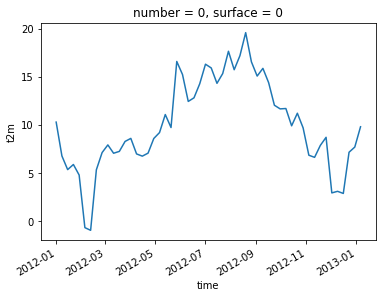

In [36]:
weekly_t2m = ds2.t2m.resample(time='W').mean()-273.15
weekly_t2m.plot()

Now we can introduce a new method.

## Rolling

Let's say that every day we need a sum of precipitation for the last N days. Xarray has a method for calculating this: **rolling()**.   

time = 7 means we are doing the sum of previous 7 days.

The data array we got using this method doesn't have a name. It also has a NaN value at the end. This is because we tried to get the 24th step of 31st December which is not there.
To make our data a bit more clean we will drop NaN values and rename our DataArray.

In [29]:
tp_day_week = daily_tp_london.rolling(time=7).sum()
tpdw = tp_day_week.rename('tp').dropna('time')
tpdw

<xarray.DataArray 'tp' (time: 360)>
array([25.98948 , 26.092388, 12.433714, ..., 36.48663 , 22.878006, 20.935637],
      dtype=float32)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2012-01-06 2012-01-07 ... 2012-12-30
    step        timedelta64[ns] 1 days
    surface     int64 0
    latitude    float64 51.5
    longitude   float64 0.1
    valid_time  (time) datetime64[ns] 2012-01-07 2012-01-08 ... 2012-12-31

#### Why did we even care if our DataArray has a name? 

Because unnamed DataArray can not be converted to pandas dataframe.

In [30]:
tpdw.to_dataframe().head(20)

,number,step,surface,latitude,longitude,valid_time,tp
time,,,,,,,
2012-01-06,0,1 days,0,51.5,0.1,2012-01-07,25.989479
2012-01-07,0,1 days,0,51.5,0.1,2012-01-08,26.092388
2012-01-08,0,1 days,0,51.5,0.1,2012-01-09,12.433714
2012-01-09,0,1 days,0,51.5,0.1,2012-01-10,12.542861
2012-01-10,0,1 days,0,51.5,0.1,2012-01-11,4.484430
2012-01-11,0,1 days,0,51.5,0.1,2012-01-12,2.249068
2012-01-12,0,1 days,0,51.5,0.1,2012-01-13,1.218539
2012-01-13,0,1 days,0,51.5,0.1,2012-01-14,1.203161
2012-01-14,0,1 days,0,51.5,0.1,2012-01-15,0.389680


### Ensemble data

ERA5 dataset offfers 10 members ensemble data on lower spatial resolution (0.5x0.5). 
In our grib file we have this ensemble data: temperature and relative humidity on 2 pressure levels (300 and 500 hPa)

In [31]:
ds_en = xr.open_dataset('data/weather/ensemble_data_pl.grib',engine = 'cfgrib')
ds_en

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 2, latitude: 35, longitude: 71, number: 10, time: 24)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 9
  * time           (time) datetime64[ns] 2019-05-05 ... 2019-05-07T21:00:00
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) int64 500 300
  * latitude       (latitude) float64 52.0 51.5 51.0 50.5 ... 36.0 35.5 35.0
  * longitude      (longitude) float64 -10.0 -9.5 -9.0 -8.5 ... 24.0 24.5 25.0
    valid_time     (time) datetime64[ns] ...
Data variables:
    t              (number, time, isobaricInhPa, latitude, longitude) float32 ...
    r              (number, time, isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Ra

Calculate ensemble mean and standard deviation.

In [32]:
ens_mean = ds_en.mean(dim='number')
ens_std = ds_en.std(dim='number')

Calculate probability that temperature at 500 hPa will be lower than -20C.  

- First we select temperature at 500 hPa and convert to C.  
- Then we make a mask using **where()**. Wherever the values are smaller than -20, the value becomes one, and anything above -20 becomes 0.  
- All we have to do now is sum along all ensemble members, divide by number of members and multiply by 100.

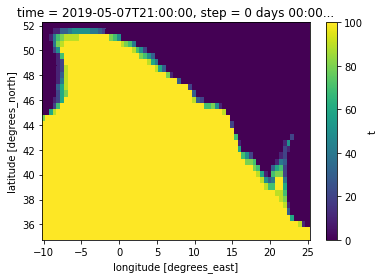

In [37]:
t_500 = ds_en.t.sel(isobaricInhPa=500)-273.15
mask = t_500.where(t_500<-20, 1).where(t_500>-20,0)
probability = mask.sum(dim='number')*10
probability.sel(time='2019-05-07T21:00:00').plot()

### A few extra examples

Let's say we have a few variables that are actually the same variable but at different levels. Example of this would be wind at 10m, 100m, 200m, or soil temperature. And we want to make them all one variable in dataset with an extra dimension being height (or depth)

In [38]:
soil_temperature_ds = xr.open_dataset('data/weather/soil_temperature.nc')

Soil temperature has 2 levels, top level and bottom, and it value is actually at the middle of this layer. (You can find documentation about this [here](https://apps.ecmwf.int/codes/grib/param-db?id=139))

In [45]:
d = [7., 28., 100., 289.]
depth = np.array([(d[0]-0.)/2, (d[1]-d[0])/2+d[0], (d[2]-d[1])/2+d[1], (d[3]-d[2])/2+d[2]])

Now we can concatenate them

In [47]:
tsl = xr.concat([soil_temperature_ds.stl1, 
                 soil_temperature_ds.stl2, 
                 soil_temperature_ds.stl3, 
                 soil_temperature_ds.stl4], 
                pd.Index(depth, name='depth'))
tsl

<xarray.DataArray (depth: 4, time: 3, latitude: 721, longitude: 1440)>
array([[[[245.41902, ..., 245.41902],
         ...,
         [231.66638, ..., 231.66638]],

        ...,

        [[245.57965, ..., 245.57965],
         ...,
         [231.66792, ..., 231.66792]]],


       ...,


       [[[245.40355, ..., 245.40355],
         ...,
         [226.15372, ..., 226.15372]],

        ...,

        [[245.85907, ..., 245.85907],
         ...,
         [226.1596 , ..., 226.1596 ]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-01-01T03:00:00
  * depth      (depth) float64 3.5 17.5 64.0 194.5
Attributes:
    units:    K

### Further reading

There are many more interesting methods for processing meteorological data.   
A few worth mentioning:
- [diff()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.diff.html#xarray.Dataset.diff) - creates difference between data over some dimension, useful for calculating pressure tendency
- [groupby()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.groupby.html) - groups by data on different dimensions. Similar to resample, but works on any dimension
- [quantile()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.quantile.html) - Compute the qth quantile of the data along the specified dimension.